Modelo LSTM para prever o parâmetro Fósforo 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import math
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize']= 18
plt.rcParams['ytick.labelsize']= 18
plt.rcParams.update({'font.size':18})

In [3]:
str_files = ''

#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'Fosforo.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

In [4]:
#df.head()

In [5]:
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']
#z.info()

In [6]:
z = z.dropna(axis=1,how='any')
#for field in z.columns:
    #print(field,'NaN',z[field].isnull().sum())
#print(len(z))

In [7]:
trainingd = z.resample('3M').mean()
trainingd
data = trainingd.iloc[:,1:2].values

train = trainingd.iloc[0:133,1:2].values  
test = trainingd.iloc[133:,1:2].values   
print('treino:',len(train))
print('teste:',len(test))
len(test)

treino: 133
teste: 33


33

In [8]:
sc = MinMaxScaler()
train_normalizado = sc.fit_transform(train)

In [9]:
timestamp = 8
previsores = []
fosforo_real    = []
for i in range(timestamp, len(train)):
    previsores.append(train_normalizado[i-timestamp:i, 0])
    fosforo_real.append(train_normalizado[i, 0])
previsores, fosforo_real = np.array(previsores), np.array(fosforo_real)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))
previsores.shape

(125, 8, 1)

In [10]:
print("Rede Neural LSTM com 10 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 10, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 10, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 10, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, fosforo_real, epochs = 100, batch_size = 32)


Rede Neural LSTM com 10 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 17s 137ms/sample - loss: 9.0113e-05
Epoch 2/100
125/125 [==============================] - 0s 3ms/sample - loss: 6.6875e-05
Epoch 3/100
125/125 [==============================] - 0s 3ms/sample - loss: 6.2904e-05
Epoch 4/100
125/125 [==============================] - 0s 3ms/sample - loss: 4.7537e-05
Epoch 5/100
125/125 [==============================] - 0s 2ms/sample - loss: 5.3190e-05
Epoch 6/100
125/125 [==============================] - 0s 3ms/sample - loss: 4.9432e-05
Epoch 7/100
125/125 [==============================] - 0s 3ms/sample - loss: 4.6830e-05
Epoch 8/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.4552e-05
Epoch 9/100
125/125 [==============================] - ETA: 0s - loss: 4.6270e-0 - 0s 3ms/sample - loss: 4.7277e-05
Epoch 10/100
125/125 [==============================] - 0s 3ms/sample - loss:

125/125 [==============================] - 0s 3ms/sample - loss: 4.1632e-05
Epoch 92/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.1340e-05
Epoch 93/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.2676e-05
Epoch 94/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.2640e-05
Epoch 95/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.4294e-05
Epoch 96/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.4376e-05
Epoch 97/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.3887e-05
Epoch 98/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.3716e-05
Epoch 99/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.2604e-05
Epoch 100/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.1237e-05


In [11]:
fosforo_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

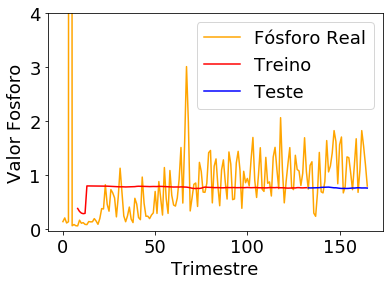

In [20]:
previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)

train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='Fósforo Real', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.ylim(-0.03,4)
plt.xlabel('Trimestre')
plt.ylabel('Valor Fosforo')
plt.legend(loc='best')
plt.show()

In [21]:
print('Previsão (média):',round(previsoes.mean(),2))
print('Fosforo Real (média):', round(fosforo_real_teste.mean(),2))
print('Diferença (média):', round(fosforo_real_teste.mean() - previsoes.mean(),2))

Previsão (média): 0.77
Fosforo Real (média): 1.12
Diferença (média): 0.35


In [22]:
train_score10 = model.evaluate(previsores, fosforo_real, verbose=0)
ph10_mse  = train_score10
ph10_rmse = math.sqrt(train_score10)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score10, math.sqrt(train_score10)))
#test_score10 = mdl.evaluate(X_test, y_test, verbose=0)
#print('Pontuação de teste: {:.2f} MSE ({:.2f} RMSE)'.format(test_score10, math.sqrt(test_score10)))

Pontuação de Treino: 0.00 MSE (0.01 RMSE)


In [23]:
print("Rede Neural LSTM com 25 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 25, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 25, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 25, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, fosforo_real, epochs = 100, batch_size = 32)

Rede Neural LSTM com 25 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 14s 113ms/sample - loss: 9.8212e-05
Epoch 2/100
125/125 [==============================] - 0s 3ms/sample - loss: 6.1843e-05
Epoch 3/100
125/125 [==============================] - 0s 2ms/sample - loss: 6.3749e-05
Epoch 4/100
125/125 [==============================] - 0s 3ms/sample - loss: 5.1237e-05
Epoch 5/100
125/125 [==============================] - 0s 2ms/sample - loss: 5.3061e-05
Epoch 6/100
125/125 [==============================] - 0s 3ms/sample - loss: 4.6166e-05
Epoch 7/100
125/125 [==============================] - 0s 2ms/sample - loss: 5.0971e-05
Epoch 8/100
125/125 [==============================] - 0s 3ms/sample - loss: 4.8026e-05
Epoch 9/100
125/125 [==============================] - 0s 3ms/sample - loss: 4.6258e-05
Epoch 10/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.5192e-05
Epoch 11/100
125

125/125 [==============================] - 0s 3ms/sample - loss: 4.1930e-05
Epoch 92/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.3076e-05
Epoch 93/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.3198e-05
Epoch 94/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.2740e-05
Epoch 95/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.3285e-05
Epoch 96/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.0813e-05
Epoch 97/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.6752e-05
Epoch 98/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.2894e-05
Epoch 99/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.3251e-05
Epoch 100/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.4474e-05


In [24]:
fosforo_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

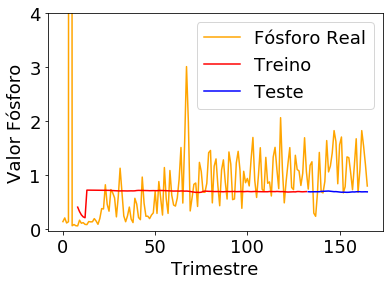

Previsão (média): 0.69
Fósforo Real (média): 1.12
Diferença (média): 0.42
Pontuação de Treino: 0.00 MSE (0.01 RMSE)


In [26]:
previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)

train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='Fósforo Real', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.ylim(-0.03,4)
plt.xlabel('Trimestre')
plt.ylabel('Valor Fósforo')
plt.legend(loc='best')
plt.show()

print('Previsão (média):',round(previsoes.mean(),2))
print('Fósforo Real (média):', round(fosforo_real_teste.mean(),2))
print('Diferença (média):', round(fosforo_real_teste.mean() - previsoes.mean(),2))

train_score25 = model.evaluate(previsores, fosforo_real, verbose=0)
ph25_mse  = train_score25
ph25_rmse = math.sqrt(train_score25)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score25, math.sqrt(train_score25)))


In [27]:
print("Rede Neural LSTM com 50 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 50, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, fosforo_real, epochs = 100, batch_size = 32)

Rede Neural LSTM com 50 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 16s 125ms/sample - loss: 9.0795e-05
Epoch 2/100
125/125 [==============================] - 0s 3ms/sample - loss: 5.7553e-05
Epoch 3/100
125/125 [==============================] - 0s 3ms/sample - loss: 4.9163e-05
Epoch 4/100
125/125 [==============================] - 0s 3ms/sample - loss: 5.1118e-05
Epoch 5/100
125/125 [==============================] - 0s 3ms/sample - loss: 4.4885e-05
Epoch 6/100
125/125 [==============================] - 0s 3ms/sample - loss: 4.4894e-05
Epoch 7/100
125/125 [==============================] - 0s 3ms/sample - loss: 4.6522e-05
Epoch 8/100
125/125 [==============================] - 0s 3ms/sample - loss: 4.2277e-05
Epoch 9/100
125/125 [==============================] - 0s 3ms/sample - loss: 4.0611e-05
Epoch 10/100
125/125 [==============================] - 0s 3ms/sample - loss: 4.5580e-05
Epoch 11/100
125

Epoch 92/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.6513e-05
Epoch 93/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.7046e-05
Epoch 94/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.6584e-05
Epoch 95/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.6418e-05
Epoch 96/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.3664e-05
Epoch 97/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.4995e-05
Epoch 98/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.4156e-05
Epoch 99/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.6618e-05
Epoch 100/100
125/125 [==============================] - 0s 2ms/sample - loss: 4.3413e-05


In [28]:
fosforo_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

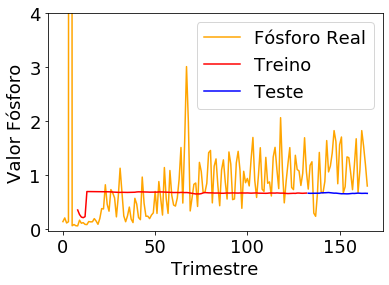

Previsão (média): 0.67
Fósforo Real (média): 1.12
Diferença (média): 0.45
Pontuação de Treino: 0.00 MSE (0.01 RMSE)


In [29]:
previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)

train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='Fósforo Real', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.ylim(-0.03,4)
plt.xlabel('Trimestre')
plt.ylabel('Valor Fósforo')
plt.legend(loc='best')
plt.show()

print('Previsão (média):',round(previsoes.mean(),2))
print('Fósforo Real (média):', round(fosforo_real_teste.mean(),2))
print('Diferença (média):', round(fosforo_real_teste.mean() - previsoes.mean(),2))

train_score50 = model.evaluate(previsores, fosforo_real, verbose=0)
ph50_mse  = train_score50
ph50_rmse = math.sqrt(train_score50)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score50, math.sqrt(train_score50)))
    


In [30]:
ph_media_mse = (ph10_mse+ph25_mse+ph50_mse)/3
ph_media_rmse = (ph10_rmse+ph25_rmse+ph50_rmse)/3

print('Fosforo_media_mse:', round(ph_media_mse,3))
print('Fosforo_media_rmse:', round(ph_media_rmse,3))

Fosforo_media_mse: 0.0
Fosforo_media_rmse: 0.006
